In [1]:
% matplotlib inline
from __future__ import print_function

from collections import Counter
import json
import os
import codecs
import glob
import math
import csv

import MeCab
import lda
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sn
from sklearn.metrics import confusion_matrix

import scipy.sparse as sparse
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# 共通関数

In [2]:
#形態素解析
def xxratax_morph(text):
    #Mecabで形態素解析
    mecab = MeCab.Tagger("-Ochasen")
    mecab.parse("")
    node = mecab.parseToNode(text)
    out_words = []
    
    #名詞だけ抽出（out_wordsに文字列を格納）
    while node:
        word_type = node.feature.split(",")[0]
        if word_type in ["名詞"]:
            out_words.append(node.surface)
        node = node.next

    return out_words    

# データの読み込みと形態素解析

In [3]:
fpath = 'data/'
fext = '.txt'
flist = []
for root, dirs, files in os.walk(fpath):
    for filename in files:
        flist.append(os.path.join(root, filename))   # ファイルのみ再帰でいい場合はここまででOK
#    for dirname in dirs:
#        found.append(os.path.join(root, dirname))    # サブディレクトリまでリストに含めたい場合はこれも書く

file_list = [l for l in flist if l.endswith('.txt')]

data/txtconvert.sh
を実行して、ファイルをUTF-8にエンコーディングする

nkf -w --overwrite */*.txt

In [4]:
doc_data = {}
vocabs = []

for fn in file_list:
    f = open(fn,'r')
    text = f.read()
    filename = fn.replace(fpath,'').replace(fext,'')
    doc_data[filename] = xxratax_morph(text)
    for w in doc_data[filename]:
        vocabs.append(w)
    #print(filename)
    f.close()

all_doc_index = doc_data.keys()
all_doc_index
all_doc_index_ar = np.array(list(all_doc_index))

In [5]:
#重複を消すためにsetしてlistにする
all_vocab = list(set(vocabs))
vocab_num = len(all_vocab)

#インデックスで使用するためにnumpy配列化
all_vocab_ar = np.array(all_vocab)

print('重複削除後の単語数: ', vocab_num)

重複削除後の単語数:  3424


In [6]:
#機械学習用データフレーム
df = pd.DataFrame()
df['filename'] = doc_data.keys()

for word in all_vocab:
    df[word] = 0

#データフレームに格納
total_elements_num = 0
df_word = pd.DataFrame([], columns = ['fileno','filename','word','num'])

for i in range(len(all_doc_index)):
    doc_idx = all_doc_index_ar[i]
    row_data = Counter(doc_data[doc_idx])
    
    for word in row_data.keys():        
        word_idx = np.where(all_vocab_ar == word)[0][0]
        #print(i, doc_idx, word, row_data[word])
        df.at[i, word] = row_data[word]
        #df2 = pd.DataFrame([[i, doc_idx, word, row_data[word]]], columns = ['fileno','filename','word','num'])
        #df_word = df_word.append(df2)
        total_elements_num += 1
                                     
print('Total elements num :', total_elements_num)
df.head(10)

Total elements num : 53840


,filename,所在,現,作成,厳守,約束,平米,脱会,通告,部門,...,マスタ,自己,題号,代理人,申し入れ,除,外部,済み,か年,条項
0,201801書式の王様/契約解除通知/売買契約解除通知書02（売主から）,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,201801書式の王様/契約解除通知/無断増改築を理由に契約解除01（借家）,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,201801書式の王様/契約解除通知/リース料不払いを理由にフランチャイズ契約の解除するため...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,201801書式の王様/契約解除通知/無断譲渡を理由に契約解除01（借家）,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,201801書式の王様/契約解除通知/現物まがい商法による契約解除をするための内容証明,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,201801書式の王様/契約解除通知/商品欠陥による契約解除をするための内容証明,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,201801書式の王様/契約解除通知/欠陥があるので契約解除,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
7,201801書式の王様/契約解除通知/フランチャイズ契約解除,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,201801書式の王様/契約解除通知/地代催告後、借地契約解除,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,201801書式の王様/契約解除通知/売買代金未払いによる契約解除,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 教師データの読み込み

In [7]:
inputfile = pd.read_csv('教師データ.csv')

In [9]:
dataset = pd.merge(df, inputfile, how="left", on="filename")
dataset['category'] = dataset['category'].replace(np.NaN,0)
dataset

,filename,所在,現,作成,厳守,約束,平米,脱会,通告,部門,...,自己,題号,代理人,申し入れ,除,外部,済み,か年,条項,category
0,201801書式の王様/契約解除通知/売買契約解除通知書02（売主から）,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9.0
1,201801書式の王様/契約解除通知/無断増改築を理由に契約解除01（借家）,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.0
2,201801書式の王様/契約解除通知/リース料不払いを理由にフランチャイズ契約の解除するため...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12.0
3,201801書式の王様/契約解除通知/無断譲渡を理由に契約解除01（借家）,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
4,201801書式の王様/契約解除通知/現物まがい商法による契約解除をするための内容証明,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12.0
5,201801書式の王様/契約解除通知/商品欠陥による契約解除をするための内容証明,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10.0
6,201801書式の王様/契約解除通知/欠陥があるので契約解除,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,8.0
7,201801書式の王様/契約解除通知/フランチャイズ契約解除,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8.0
8,201801書式の王様/契約解除通知/地代催告後、借地契約解除,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,20.0
9,201801書式の王様/契約解除通知/売買代金未払いによる契約解除,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10.0


# 機械学習（SVM）

In [10]:
from sklearn import svm
from sklearn import cross_validation

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [11]:
#目的変数と説明変数の設定
target_col = 'category'
exclude_cols = ['id', 'filename','datatype','category']
feature_cols = [col for col in dataset.columns if col not in exclude_cols]

In [12]:
#SVM
clf = svm.SVC(C=100, kernel="linear", cache_size=200, class_weight=None, coef0=0.0, degree=3,gamma=0.001, max_iter=-1, probability=False,random_state=None, shrinking=True, tol=0.001, verbose=False)

In [13]:
#クロスバリデーション
def get_accuracy(clf, x, y):
    scores = cross_validation.cross_val_score(clf, x, y, cv=10)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [14]:
x_cv_data = dataset[feature_cols]
y_cv_data = dataset[target_col]

#get_accuracy(clf, x_cv_data, y_cv_data)

In [ ]:
#グリッドサーチでパラメータ推定

In [41]:
#最尤推定後のパラメータでSVMを設定

In [15]:
#データを分割して実行し、予測結果項目をデータフレームに追加
#①datasetをランダムにソートする。
dataset.reindex(np.random.permutation(dataset.index)).reset_index(drop=True)

#②分割数nで割り、余りをdatatype項目として設定
n = 10
dataset['datatype'] = dataset.index%n

#③forループして、datatype=iをテストデータ、他を学習データに分割
i = 0
for i in range(n):
    train_data = dataset[dataset.datatype != i]
    test_data = dataset[dataset.datatype == i]
    
    #学習処理
    train_feature = train_data[feature_cols]
    train_target = train_data[target_col]
    clf.fit(train_feature, train_target)
    
    #予測処理 > 予測結果をデータフレームに格納
    test_feature = test_data[feature_cols]
    test_predicted = clf.predict(test_feature)
    test_data['predicted'] = test_predicted
    dataset.at[test_data.index, 'predicted'] = test_data['predicted']

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


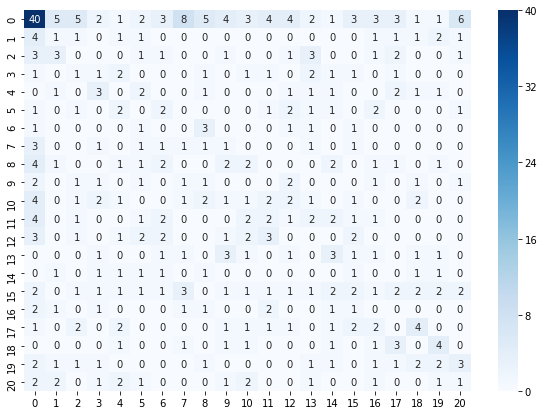

In [16]:
#予測・実績のコンフュージョンマトリクスを作成
def print_cmx(x, y):
    labels = sorted(list((0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20)))
    cmx_data = confusion_matrix(x, y, labels=labels)    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cmx, annot=True, cmap='Blues')
    plt.show()

print_cmx(dataset['predicted'], dataset['category'])

In [19]:
dataset

,filename,所在,現,作成,厳守,約束,平米,脱会,通告,部門,...,代理人,申し入れ,除,外部,済み,か年,条項,category,datatype,predicted
0,201801書式の王様/契約解除通知/売買契約解除通知書02（売主から）,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,9.0,0,8.0
1,201801書式の王様/契約解除通知/無断増改築を理由に契約解除01（借家）,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3.0,1,14.0
2,201801書式の王様/契約解除通知/リース料不払いを理由にフランチャイズ契約の解除するため...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,12.0,2,11.0
3,201801書式の王様/契約解除通知/無断譲渡を理由に契約解除01（借家）,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1.0,3,20.0
4,201801書式の王様/契約解除通知/現物まがい商法による契約解除をするための内容証明,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,12.0,4,17.0
5,201801書式の王様/契約解除通知/商品欠陥による契約解除をするための内容証明,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,10.0,5,8.0
6,201801書式の王様/契約解除通知/欠陥があるので契約解除,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,8.0,6,10.0
7,201801書式の王様/契約解除通知/フランチャイズ契約解除,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,8.0,7,6.0
8,201801書式の王様/契約解除通知/地代催告後、借地契約解除,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,20.0,8,2.0
9,201801書式の王様/契約解除通知/売買代金未払いによる契約解除,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,10.0,9,3.0


# LDAでトピックモデル化

#LDA（トピック数は5）
topic_num = 5
model1 = LatentDirichletAllocation(n_topics = topic_num,
                                   doc_topic_prior=0.001,
                                   topic_word_prior=0.5,
                                   max_iter=5,
                                   learning_method='online',
                                   learning_offset=50.,
                                   random_state=0)

#スパース行列をLDAでトピック化
model1.fit(sps_ar)

#正規化
normalize_components = model1.components_ / model1.components_.sum(axis=0)

#LDA内のトピックと単語の組み合わせ
n_top_words = 20
for topic_idx, topic in enumerate(normalize_components):
    print('Topic #%d:' % topic_idx)
    print(' '.join([all_vocab_ar[i] for i in
                    topic.argsort()[:-n_top_words - 1:-1]]))
    print()

#文書あたりのトピックの重要度
doc_topic_data = model1.transform(sps_ar)

#正規化
normalize_doc_topic_data = doc_topic_data / doc_topic_data.sum(axis=1, keepdims=True)

#LDA内の文章とトピックの組み合わせ
df=pd.DataFrame()
df['filename']= doc_data.keys()

i=0
t='topic'

while i < topic_num:
    df[t+str(i)]=''
    i=i+1

i=0
for dfile in doc_data.keys():
    #print(dfile)
    for topic_idx, prob in enumerate(normalize_doc_topic_data[i]):
        df[t+str(topic_idx)][df['filename']==dfile] = prob
        #print('Topic #%d: probality: %f' % (topic_idx, prob))
    i=i+1

df